# Data Preprocessing

#### Import all packages

In [5]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from scipy.io import arff
import numpy as np
import pandas as pd
#import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
#import fancyimpute
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

#### Load data and transform into dataframe 

In [6]:
def load_data():
    df = []
    for i in range(5):
        df.append(arff.loadarff('data/'+str(i+1)+'year.arff'))
    return df

In [7]:
def load_dataframe():
    return [pd.DataFrame(j[0]) for j in load_data()]

In [8]:
data = load_dataframe()
print(data)

[         Attr1     Attr2     Attr3      Attr4     Attr5     Attr6     Attr7  \
0     0.200550  0.379510  0.396410    2.04720   32.3510  0.388250  0.249760   
1     0.209120  0.499880  0.472250    1.94470   14.7860  0.000000  0.258340   
2     0.248660  0.695920  0.267130    1.55480   -1.1523  0.000000  0.309060   
3     0.081483  0.307340  0.458790    2.49280   51.9520  0.149880  0.092704   
4     0.187320  0.613230  0.229600    1.40630   -7.3128  0.187320  0.187320   
5     0.228220  0.497940  0.359690    1.75020  -47.7170  0.000000  0.281390   
6     0.111090  0.647440  0.289710    1.47050    2.5349  0.000000  0.111090   
7     0.532320  0.027059  0.705540   53.95400  299.5800  0.000000  0.652400   
8     0.009020  0.632020  0.053735    1.12630  -37.8420  0.000000  0.014434   
9     0.124080  0.838370  0.142040    1.16940  -91.8830  0.000000  0.153280   
10    0.240010  0.443550  0.188350    1.44000  -21.1650 -0.931900  0.240010   
11   -0.027117  0.111480  0.119890    2.07540  -31.

In [5]:
for df in data:
    numRows, numCols = df.shape

    cols = ['X'+str(i+1) for i in range(numCols-1)]
    cols.append('Y')
    df.columns  = cols


#### Drop all missing values 

In [6]:
def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = [df.dropna(axis=0, how='any') for df in dataframes]
    if verbose:
        for i in range(len(dataframes)):
            print(str(i+1)+'year:','Original Length=', len(dataframes[i]), '\tCleaned Length=', len(clean_dataframes[i]), '\tMissing Data=', len(dataframes[i])-len(clean_dataframes[i]))
    return clean_dataframes

# Doing a quick analysis of how many missing values are there in each of the 5 dataframes
nan_dropped_dataframes = drop_nan_rows(data, verbose=True)



1year: Original Length= 7027 	Cleaned Length= 3194 	Missing Data= 3833
2year: Original Length= 10173 	Cleaned Length= 4088 	Missing Data= 6085
3year: Original Length= 10503 	Cleaned Length= 4885 	Missing Data= 5618
4year: Original Length= 9792 	Cleaned Length= 4769 	Missing Data= 5023
5year: Original Length= 5910 	Cleaned Length= 3031 	Missing Data= 2879


#### The heatmap of missing values in the first year

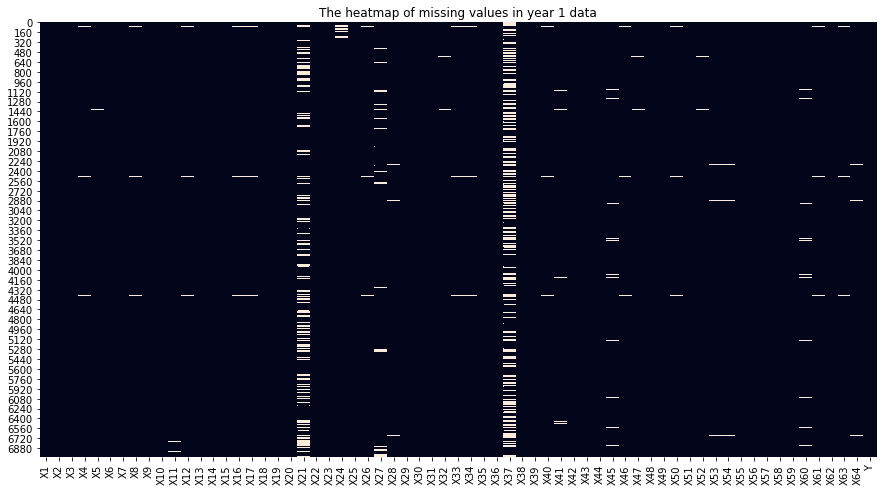

In [7]:
fig, ax = plt.subplots(figsize=(15,8))  
sns.heatmap(data[0].isnull(),cbar = False,ax =ax)
plt.title("The heatmap of missing values in year 1 data")
plt.savefig('Heatmap_year1.png')

#### The Imbalance between Bankcrupt and Non-Bankcrupt classes

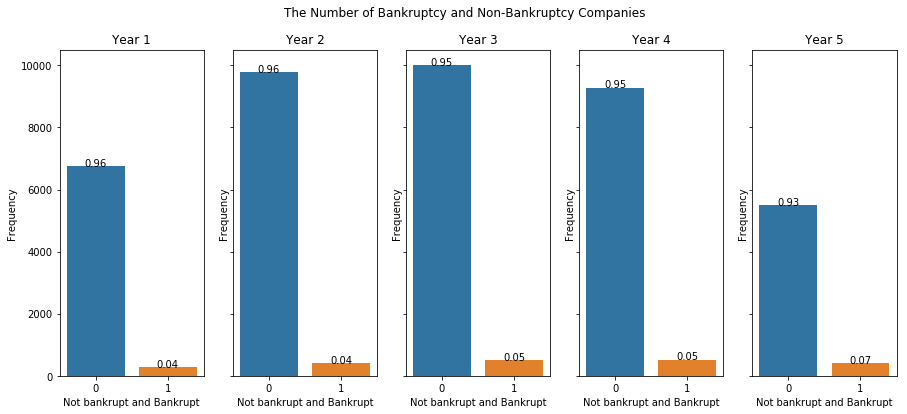

In [8]:
for df in data:
    labels = pd.factorize(df['Y'])[0]
    df['Y'] = labels


fig, ax = plt.subplots(figsize=(15,6), ncols=5, nrows=1, sharey = 'row')
title = fig.suptitle("The Number of Bankruptcy and Non-Bankruptcy Companies")

for i in range(0,5):
    sns.countplot("Y",  data = data[i], ax = ax[i])
    ax[i].set_title("Year"+ "i")
    for p in ax[i].patches:
        height = p.get_height()
        ax[i].text(p.get_x()+p.get_width()/2.,
                height + 10,
                '{:1.2f}'.format(height/len(data[i])),
                ha="center") 
    ax[i].set_xlabel('Not bankrupt and Bankrupt')
    ax[i].set_ylabel('Frequency')
fig.savefig('The frequency of the number of bankruptcy companies')

#### Filling all missing values with mean imputation, KNN imputation and Iterative imputation 

In [9]:
def perform_mean_imputation(dfs):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
    imputer = Imputer(missing_values=np.nan, strategy='mean', axis=0)
    mean_imputed_dfs = [pd.DataFrame(imputer.fit_transform(df)) for df in dfs]
    for i in range(len(dfs)):
        mean_imputed_dfs[i].columns = dfs[i].columns   
    return mean_imputed_dfs

mean_imputed_dataframes = perform_mean_imputation(data)

In [83]:
def perform_knn_imputation(dfs):
    knn_imputed_datasets = [fancyimpute.KNN(k=50,verbose=True).fit_transform(dfs[i]) for i in range(len(dfs))]
    
    return [pd.DataFrame(data=knn_imputed_datasets[i]) for i in range(len(dfs))]

knn_imputed_dataframes = perform_knn_imputation(data)

#print("knnImpute MSE: %f" % knn_mse)


Imputing row 1/7027 with 0 missing, elapsed time: 14.518
Imputing row 101/7027 with 1 missing, elapsed time: 14.528
Imputing row 201/7027 with 2 missing, elapsed time: 14.534
Imputing row 301/7027 with 0 missing, elapsed time: 14.540
Imputing row 401/7027 with 0 missing, elapsed time: 14.545
Imputing row 501/7027 with 1 missing, elapsed time: 14.550
Imputing row 601/7027 with 1 missing, elapsed time: 14.555
Imputing row 701/7027 with 1 missing, elapsed time: 14.560
Imputing row 801/7027 with 0 missing, elapsed time: 14.564
Imputing row 901/7027 with 0 missing, elapsed time: 14.569
Imputing row 1001/7027 with 1 missing, elapsed time: 14.578
Imputing row 1101/7027 with 1 missing, elapsed time: 14.584
Imputing row 1201/7027 with 3 missing, elapsed time: 14.590
Imputing row 1301/7027 with 1 missing, elapsed time: 14.595
Imputing row 1401/7027 with 1 missing, elapsed time: 14.600
Imputing row 1501/7027 with 1 missing, elapsed time: 14.605
Imputing row 1601/7027 with 1 missing, elapsed time:

Imputing row 8101/10173 with 0 missing, elapsed time: 34.076
Imputing row 8201/10173 with 0 missing, elapsed time: 34.080
Imputing row 8301/10173 with 1 missing, elapsed time: 34.087
Imputing row 8401/10173 with 0 missing, elapsed time: 34.099
Imputing row 8501/10173 with 3 missing, elapsed time: 34.106
Imputing row 8601/10173 with 0 missing, elapsed time: 34.118
Imputing row 8701/10173 with 0 missing, elapsed time: 34.128
Imputing row 8801/10173 with 0 missing, elapsed time: 34.137
Imputing row 8901/10173 with 2 missing, elapsed time: 34.149
Imputing row 9001/10173 with 2 missing, elapsed time: 34.158
Imputing row 9101/10173 with 2 missing, elapsed time: 34.168
Imputing row 9201/10173 with 0 missing, elapsed time: 34.177
Imputing row 9301/10173 with 1 missing, elapsed time: 34.188
Imputing row 9401/10173 with 0 missing, elapsed time: 34.198
Imputing row 9501/10173 with 2 missing, elapsed time: 34.207
Imputing row 9601/10173 with 0 missing, elapsed time: 34.215
Imputing row 9701/10173 

Imputing row 3201/9792 with 0 missing, elapsed time: 29.538
Imputing row 3301/9792 with 0 missing, elapsed time: 29.546
Imputing row 3401/9792 with 1 missing, elapsed time: 29.555
Imputing row 3501/9792 with 1 missing, elapsed time: 29.564
Imputing row 3601/9792 with 3 missing, elapsed time: 29.574
Imputing row 3701/9792 with 1 missing, elapsed time: 29.581
Imputing row 3801/9792 with 1 missing, elapsed time: 29.589
Imputing row 3901/9792 with 0 missing, elapsed time: 29.596
Imputing row 4001/9792 with 0 missing, elapsed time: 29.602
Imputing row 4101/9792 with 0 missing, elapsed time: 29.609
Imputing row 4201/9792 with 0 missing, elapsed time: 29.621
Imputing row 4301/9792 with 1 missing, elapsed time: 29.626
Imputing row 4401/9792 with 0 missing, elapsed time: 29.633
Imputing row 4501/9792 with 1 missing, elapsed time: 29.640
Imputing row 4601/9792 with 2 missing, elapsed time: 29.645
Imputing row 4701/9792 with 0 missing, elapsed time: 29.650
Imputing row 4801/9792 with 3 missing, e

In [ ]:
def perform_II_imputation(dfs):
    dfs_II = dfs.copy()
    for i in range(len(dfs)):
        imp = Imputer(strategy="mean", axis=0)
        scale = StandardScaler()
        dfs_II[i] =  scale.fit_transform(imp.fit_transform(dfs[i]))
    II_imputed_datasets = [fancyimpute.IterativeImputer().fit_transform(dfs_II[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=II_imputed_datasets[i]) for i in range(len(dfs))]
    
II_imputed_dataframes = perform_II_imputation(data)

In [10]:
def split_dataframes_features_labels(dfs):
    feature_dfs = [dfs[i].iloc[:,0:64] for i in range(len(dfs))]
    label_dfs = [dfs[i].iloc[:,64] for i in range(len(dfs))]
    return feature_dfs, label_dfs

feature_dfs, label_dfs = split_dataframes_features_labels(data)


#### Split and prepare dataset

In [11]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=False, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(5, feature_dfs[0], label_dfs[0], verbose = False)


In [12]:
def score_dataset(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

In [13]:
X_train = X_train_list[0]
X_test = X_test_list[0]
y_train = y_train_list[0]
y_test = y_test_list[0]
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_test  = X_test.drop(cols_with_missing, axis=1)
print("Mean Absolute Error from dropping columns with Missing Values:")
print(score_dataset(reduced_X_train, reduced_X_test, y_train, y_test))


Mean Absolute Error from dropping columns with Missing Values:


/Users/maggieliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.04220009483167378


In [14]:
feature_dfs_mean, label_dfs_mean = split_dataframes_features_labels(mean_imputed_dataframes)
X_train_list_mean, y_train_list_mean, X_test_list_mean, y_test_list_mean = prepare_kfold_cv_data(5, feature_dfs_mean[0], label_dfs_mean[0], verbose = False)

X_train_mean = X_train_list_mean[0]
X_test_mean = X_test_list_mean[0]

X_train_mean = pd.DataFrame(X_train_mean)
X_test_mean = pd.DataFrame(X_test_mean)

print("Mean Absolute Error from Imputation:")
print(score_dataset(X_train_mean, X_test_mean, y_train, y_test))

Mean Absolute Error from Imputation:


/Users/maggieliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.027951635846372686


In [90]:
feature_dfs_knn, label_dfs_knn = split_dataframes_features_labels(knn_imputed_dataframes)
X_train_list_knn, y_train_list_knn, X_test_list_knn, y_test_list_knn = prepare_kfold_cv_data(5, feature_dfs_knn[0], label_dfs_knn[0], verbose = False)

X_train_knn = X_train_list_knn[0]
X_test_knn = X_test_list_knn[0]

X_train_knn = pd.DataFrame(X_train_knn)
X_test_knn = pd.DataFrame(X_test_knn)

print("Mean Absolute Error from KNN Imputation:")
print(score_dataset(X_train_knn, X_test_knn, y_train, y_test))

Mean Absolute Error from KNN Imputation:
0.03997155049786629


In [91]:
feature_dfs_II, label_dfs_II = split_dataframes_features_labels(II_imputed_dataframes)
X_train_list_II, y_train_list_II, X_test_list_II, y_test_list_II = prepare_kfold_cv_data(5, feature_dfs_II[0], label_dfs_II[0], verbose = False)

X_train_II = X_train_list_II[0]
X_test_II = X_test_list_II[0]

X_train_II = pd.DataFrame(X_train_II)
X_test_II = pd.DataFrame(X_test_II)

print("Mean Absolute Error from Iterative Imputation:")
print(score_dataset(X_train_II, X_test_II, y_train, y_test))

Mean Absolute Error from Iterative Imputation:
0.028805120910384067


#### Oversampling  

In [15]:
#upsampled
year1 = mean_imputed_dataframes[0]
Not_bankcrupt = year1[year1['Y'] == 0.0]
bankcrupt = year1[year1['Y'] == 1.0]
bankcrupt_upsampled = resample(bankcrupt,
                          replace=True, # sample with replacement
                          n_samples=len(Not_bankcrupt), # match number in majority class
                          random_state=27) # reproducible results
upsampled = pd.concat([Not_bankcrupt, bankcrupt_upsampled])
print(len(upsampled))

13512


In [16]:
#downsampled
Not_bankcrupt_downsampled = resample(Not_bankcrupt,
                                replace = False, # sample without replacement
                                n_samples = len(bankcrupt), # match minority n
                                random_state = 27) # reproducible results
downsampled = pd.concat([Not_bankcrupt_downsampled, bankcrupt])
print(len(downsampled))

542


In [15]:
def oversample_data_SMOTE(dfs):
    smote = SMOTE(random_state=27, ratio=1.0)
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    resampled_feature_arrays = []
    resampled_label_arrays = []
    for i in range(len(dfs)):
        print('Original dataset shape {}'.format(Counter(label_dfs[i])))
        dfi_features_res, dfi_label_res = smote.fit_sample(feature_dfs[i], label_dfs[i])
        print('Resampled dataset shape {}\n'.format(Counter(dfi_label_res)))
        resampled_feature_arrays.append(dfi_features_res)
        resampled_label_arrays.append(dfi_label_res)
        
    return resampled_feature_arrays, resampled_label_arrays

def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs = []
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
        label_df.columns=['Y'] 
        resampled_dfs.append(feature_df.join(label_df))
    # re-assign the column headers for features and labels    
    #set_new_headers(resampled_dfs)    
    return resampled_dfs

smote_feature_arrays, smote_label_arrays = oversample_data_SMOTE(mean_imputed_dataframes)
oversampled_dataframes = restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)



Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Original dataset shape Counter({0.0: 9773, 1.0: 400})
Resampled dataset shape Counter({0.0: 9773, 1.0: 9773})

Original dataset shape Counter({0.0: 10008, 1.0: 495})


/Users/maggieliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/maggieliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/maggieliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Resampled dataset shape Counter({0.0: 10008, 1.0: 10008})

Original dataset shape Counter({0.0: 9277, 1.0: 515})
Resampled dataset shape Counter({0.0: 9277, 1.0: 9277})

Original dataset shape Counter({0.0: 5500, 1.0: 410})
Resampled dataset shape Counter({0.0: 5500, 1.0: 5500})



/Users/maggieliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/maggieliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
feature, label = split_dataframes_features_labels(oversampled_dataframes)

#lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(feature[0], label[0])
#model = SelectFromModel(lsvc, prefit=True)
#X_new = model.transform(feature[0])
#X_new.shape
year1_feature = feature[0]
year1_label = label[0]

year1_label_train = year1_label[:50].append( year1_label[-50:])

year1_feature_train = year1_feature[:50].append(year1_feature[-50:])

# Feature selection

#### PCA dimensionality reduction

[2.04363352e-01 1.47256469e-01 1.10419127e-01 9.10364177e-02
 6.47172645e-02 4.46622843e-02 4.26628541e-02 3.14682208e-02
 3.09248438e-02 2.42387550e-02 1.82259494e-02 1.79683751e-02
 1.71255959e-02 1.68889955e-02 1.56586010e-02 1.55817430e-02
 1.54199633e-02 1.43962288e-02 1.35476866e-02 1.19653166e-02
 1.13211097e-02 8.58252692e-03 7.30159758e-03 7.03231283e-03
 5.77271756e-03 4.13498370e-03 1.74315620e-03 1.42881929e-03
 9.88302637e-04 5.56924736e-04 5.02950933e-04 4.19517207e-04
 3.25078558e-04 3.12027798e-04 2.44796753e-04 2.35383028e-04
 1.31366982e-04 1.18150587e-04 8.37765475e-05 5.79897159e-05
 5.50641840e-05 3.19644393e-05 2.84662596e-05 1.99597862e-05
 1.58520664e-05 1.30094010e-05 4.67529707e-06 3.93860700e-06
 2.86444157e-06 1.52109375e-06 4.74838780e-07 1.75810377e-07
 1.63635192e-07 1.40333042e-07 1.15858389e-07 4.00189779e-08
 2.91178660e-08 7.78535268e-09 4.25078581e-09 5.07042245e-12
 2.52659117e-12 4.63265505e-18 4.03035646e-32 9.90619270e-34]


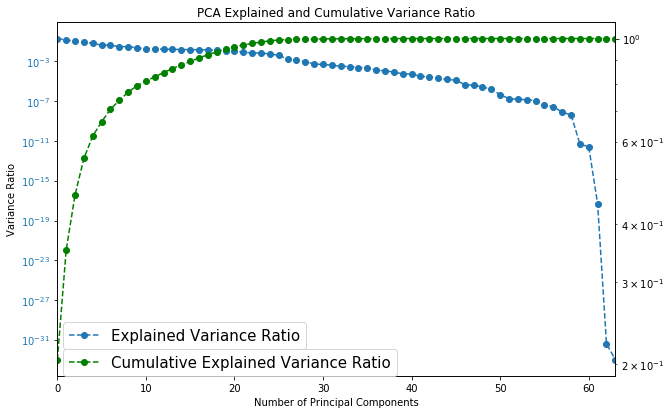

In [19]:
from sklearn.decomposition import PCA

z_scaler = StandardScaler()
#data = ds.load_breast_cancer()['data'];

normalized_year1_feature = z_scaler.fit_transform(year1_feature)
pca_trafo = PCA().fit(normalized_year1_feature);
print(pca_trafo.explained_variance_ratio_)
fig, ax1 = plt.subplots(figsize = (10,6.5))

ax1.semilogy(pca_trafo.explained_variance_ratio_, '--o', label = 'Explained Variance Ratio');
color =  ax1.lines[0].get_color()
ax1.set_xlabel('Number of Principal Components');
for tl in ax1.get_yticklabels():
    tl.set_color(color)
plt.ylabel('Variance Ratio')
plt.legend(loc=(0.01, 0.075) ,fontsize = 15);

ax2 = ax1.twinx()
ax2.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--go', label = 'Cumulative Explained Variance Ratio');
for tl in ax2.get_yticklabels():
    tl.set_color('black')

#ax1.tick_params(axis='both', which='major', labelsize=18);
#ax1.tick_params(axis='both', which='minor', labelsize=12);
#ax2.tick_params(axis='both', which='major', labelsize=18);
#ax2.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 63]);
plt.title('PCA Explained and Cumulative Variance Ratio')

plt.legend(loc=(0.01, 0),fontsize = 15);

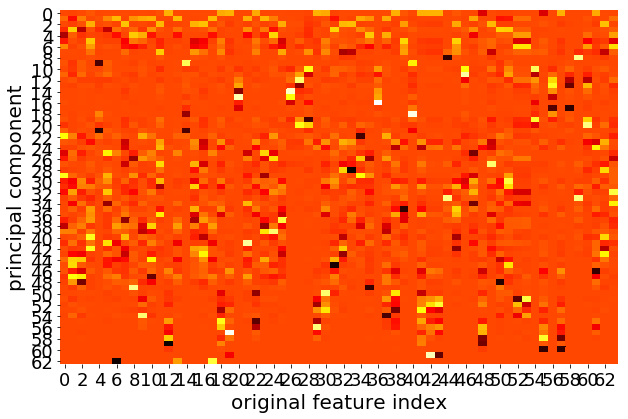

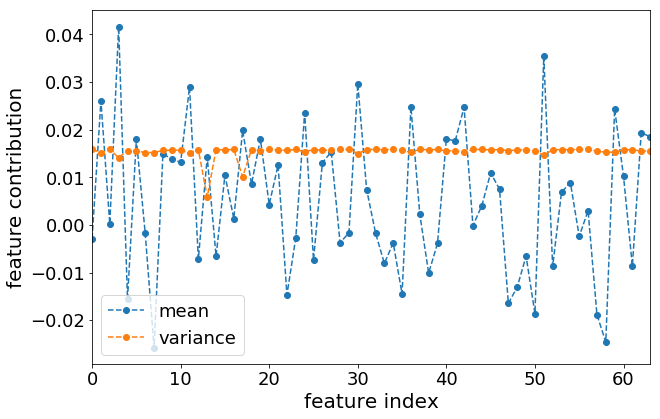

In [19]:
n_comp =63
pca_trafo = PCA(n_components=n_comp)


z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(year1_feature)

pca_data = pca_trafo.fit_transform(z_data)
pca_inv_data = pca_trafo.inverse_transform(np.eye(n_comp))

fig = plt.figure(figsize=(10, 6.5))
sns.heatmap(pca_trafo.inverse_transform(np.eye(n_comp)), cmap="hot", cbar=False)
plt.ylabel('principal component', fontsize=20);
plt.xlabel('original feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);

fig = plt.figure(figsize=(10, 6.5))
plt.plot(pca_inv_data.mean(axis=0), '--o', label = 'mean')
plt.plot(np.square(pca_inv_data.std(axis=0)), '--o', label = 'variance')
plt.legend(loc='lower right')
plt.ylabel('feature contribution', fontsize=20);
plt.xlabel('feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 63])
plt.legend(loc='lower left', fontsize=18)

In [23]:
#PCA dimensionality reduction
pca = PCA(n_components=20)
principal_components = pca.fit_transform(normalized_year1_feature)
principal_df = pd.DataFrame(data = principal_components)


# Modeling 

#### T-SNE Data Visualization

In [93]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(year1_feature)


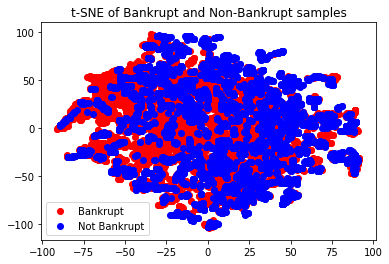

In [92]:
X_pca = TSNE(n_components=2).fit_transform(principal_components)
year1_bankcrupt = list(range(6756))
year1_not_bankcrupt = list(range(6756,13512))
plt.scatter(X_pca[year1_bankcrupt][:,0], X_pca[year1_bankcrupt][:,1],c="r",label = "Bankrupt")
plt.scatter(X_pca[year1_not_bankcrupt][:,0], X_pca[year1_not_bankcrupt][:,1],c="b",label = "Not Bankrupt")
plt.title("t-SNE of Bankrupt and Non-Bankrupt samples")
plt.legend(loc = "best")

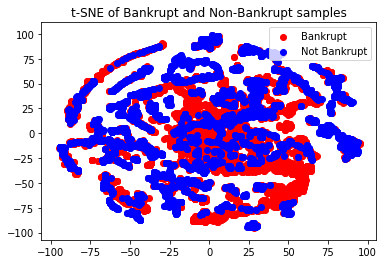

In [94]:
year1_bankcrupt = list(range(6756))
year1_not_bankcrupt = list(range(6756,13512))
plt.scatter(X_embedded[year1_bankcrupt][:,0], X_embedded[year1_bankcrupt][:,1],c="r",label = "Bankrupt")
plt.scatter(X_embedded[year1_not_bankcrupt][:,0], X_embedded[year1_not_bankcrupt][:,1],c="b",label = "Not Bankrupt")
plt.title("t-SNE of Bankrupt and Non-Bankrupt samples")
plt.legend(loc = "best")

#### SVM Model

In [24]:
from scipy.optimize import minimize
from scipy.special import expit
from scipy.linalg import solve_triangular

from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics.pairwise import (
    linear_kernel,
    rbf_kernel,
    polynomial_kernel
)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils.validation import check_X_y


class BaseRVM(BaseEstimator):

    """Base Relevance Vector Machine class.
    Implementation of Mike Tipping's Relevance Vector Machine using the
    scikit-learn API. Add a posterior over weights method and a predict
    in subclass to use for classification or regression.
    """

    def __init__(
        self,
        kernel='rbf',
        degree=3,
        coef1=None,
        coef0=0.0,
        n_iter=3000,
        tol=1e-3,
        alpha=1e-6,
        threshold_alpha=1e9,
        beta=1.e-6,
        beta_fixed=False,
        bias_used=True,
        verbose=False
    ):
        """Copy params to object properties, no validation."""
        self.kernel = kernel
        self.degree = degree
        self.coef1 = coef1
        self.coef0 = coef0
        self.n_iter = n_iter
        self.tol = tol
        self.alpha = alpha
        self.threshold_alpha = threshold_alpha
        self.beta = beta
        self.beta_fixed = beta_fixed
        self.bias_used = bias_used
        self.verbose = verbose

    def get_params(self, deep=True):
        """Return parameters as a dictionary."""
        params = {
            'kernel': self.kernel,
            'degree': self.degree,
            'coef1': self.coef1,
            'coef0': self.coef0,
            'n_iter': self.n_iter,
            'tol': self.tol,
            'alpha': self.alpha,
            'threshold_alpha': self.threshold_alpha,
            'beta': self.beta,
            'beta_fixed': self.beta_fixed,
            'bias_used': self.bias_used,
            'verbose': self.verbose
        }
        return params

    def set_params(self, **parameters):
        """Set parameters using kwargs."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def _apply_kernel(self, x, y):
        """Apply the selected kernel function to the data."""
        if self.kernel == 'linear':
            phi = linear_kernel(x, y)
        elif self.kernel == 'rbf':
            phi = rbf_kernel(x, y, self.coef1)
        elif self.kernel == 'poly':
            phi = polynomial_kernel(x, y, self.degree, self.coef1, self.coef0)
        elif callable(self.kernel):
            phi = self.kernel(x, y)
            if len(phi.shape) != 2:
                raise ValueError(
                    "Custom kernel function did not return 2D matrix"
                )
            if phi.shape[0] != x.shape[0]:
                raise ValueError(
                    "Custom kernel function did not return matrix with rows"
                    " equal to number of data points."""
                )
        else:
            raise ValueError("Kernel selection is invalid.")

        if self.bias_used:
            phi = np.append(phi, np.ones((phi.shape[0], 1)), axis=1)

        return phi

    def _prune(self):
        """Remove basis functions based on alpha values."""
        keep_alpha = self.alpha_ < self.threshold_alpha

        if not np.any(keep_alpha):
            keep_alpha[0] = True
            if self.bias_used:
                keep_alpha[-1] = True

        if self.bias_used:
            if not keep_alpha[-1]:
                self.bias_used = False
            self.relevance_ = self.relevance_[keep_alpha[:-1]]
        else:
            self.relevance_ = self.relevance_[keep_alpha]
            
        print(self.alpha_)
        print(self.gamma)
        self.alpha_ = self.alpha_[keep_alpha]
        self.alpha_old = self.alpha_old[keep_alpha]
        self.gamma = self.gamma[keep_alpha]
        self.phi = self.phi[:, keep_alpha]
        self.sigma_ = self.sigma_[np.ix_(keep_alpha, keep_alpha)]
        self.m_ = self.m_[keep_alpha]

    def fit(self, X, y):
        """Fit the RVR to the training data."""
        X, y = check_X_y(X, y)

        n_samples, n_features = X.shape

        self.phi = self._apply_kernel(X, X)

        n_basis_functions = self.phi.shape[1]

        self.relevance_ = X
        self.y = y

        self.alpha_ = self.alpha * np.ones(n_basis_functions)
        self.beta_ = self.beta

        self.m_ = np.zeros(n_basis_functions)

        self.alpha_old = self.alpha_

        for i in range(self.n_iter):
            self._posterior()

            self.gamma = 1 - self.alpha_*np.diag(self.sigma_)
            self.alpha_ = self.gamma/(self.m_ ** 2)

            if not self.beta_fixed:
                self.beta_ = (n_samples - np.sum(self.gamma))/(
                    np.sum((y - np.dot(self.phi, self.m_)) ** 2))

            self._prune()

            if self.verbose:
                print("Iteration: {}".format(i))
                print("Alpha: {}".format(self.alpha_))
                print("Beta: {}".format(self.beta_))
                print("Gamma: {}".format(self.gamma))
                print("m: {}".format(self.m_))
                print("Relevance Vectors: {}".format(self.relevance_.shape[0]))
                print()

            delta = np.amax(np.absolute(self.alpha_ - self.alpha_old))

            if delta < self.tol and i > 1:
                break

            self.alpha_old = self.alpha_

        if self.bias_used:
            self.bias = self.m_[-1]
        else:
            self.bias = None

        return self


class RVR(BaseRVM, RegressorMixin):

    """Relevance Vector Machine Regression.
    Implementation of Mike Tipping's Relevance Vector Machine for regression
    using the scikit-learn API.
    """

    def _posterior(self):
        """Compute the posterior distriubtion over weights."""
        i_s = np.diag(self.alpha_) + self.beta_ * np.dot(self.phi.T, self.phi)
        self.sigma_ = np.linalg.inv(i_s)
        self.m_ = self.beta_ * np.dot(self.sigma_, np.dot(self.phi.T, self.y))

    def predict(self, X, eval_MSE=False):
        """Evaluate the RVR model at x."""
        phi = self._apply_kernel(X, self.relevance_)

        y = np.dot(phi, self.m_)

        if eval_MSE:
            MSE = (1/self.beta_) + np.dot(phi, np.dot(self.sigma_, phi.T))
            return y, MSE[:, 0]
        else:
            return y


class RVC(BaseRVM, ClassifierMixin):

    """Relevance Vector Machine Classification.
    Implementation of Mike Tipping's Relevance Vector Machine for
    classification using the scikit-learn API.
    """

    def __init__(self, n_iter_posterior=50, **kwargs):
        """Copy params to object properties, no validation."""
        self.n_iter_posterior = n_iter_posterior
        super(RVC, self).__init__(**kwargs)

    def get_params(self, deep=True):
        """Return parameters as a dictionary."""
        params = super(RVC, self).get_params(deep=deep)
        params['n_iter_posterior'] = self.n_iter_posterior
        return params

    def _classify(self, m, phi):
        return expit(np.dot(phi, m))

    def _log_posterior(self, m, alpha, phi, t):

        y = self._classify(m, phi)

        log_p = -1 * (np.sum(np.log(y[t == 1]), 0) +
                      np.sum(np.log(1-y[t == 0]), 0))
        log_p = log_p + 0.5*np.dot(m.T, np.dot(np.diag(alpha), m))

        jacobian = np.dot(np.diag(alpha), m) - np.dot(phi.T, (t-y))

        return log_p, jacobian

    def _hessian(self, m, alpha, phi, t):
        y = self._classify(m, phi)
        B = np.diag(y*(1-y))
        return np.diag(alpha) + np.dot(phi.T, np.dot(B, phi))

    def _posterior(self):
        result = minimize(
            fun=self._log_posterior,
            hess=self._hessian,
            x0=self.m_,
            args=(self.alpha_, self.phi, self.t),
            method='Newton-CG',
            jac=True,
            options={
                'maxiter': self.n_iter_posterior
            }
        )

        self.m_ = result.x
        try:
            self.sigma_ = np.linalg.inv(
                self._hessian(self.m_, self.alpha_, self.phi, self.t)
            )
        except:
            q, r = np.linalg.qr(self._hessian(self.m_, self.alpha_, self.phi, self.t))
            ri = solve_triangular(r, np.identity(r.shape[0]))
            self.sigma_ = np.dot(ri, q.T)

    def fit(self, X, y):
        """Check target values and fit model."""
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        if n_classes < 2:
            raise ValueError("Need 2 or more classes.")
        elif n_classes == 2:
            self.t = np.zeros(y.shape)
            self.t[y == self.classes_[1]] = 1
            return super(RVC, self).fit(X, self.t)
        else:
            self.multi_ = None
            self.multi_ = OneVsOneClassifier(self)
            self.multi_.fit(X, y)
            return self

    def predict_proba(self, X):
        """Return an array of class probabilities."""
        phi = self._apply_kernel(X, self.relevance_)
        y = self._classify(self.m_, phi)
        return np.column_stack((1-y, y))

    def predict(self, X):
        """Return an array of classes for each input."""
        if len(self.classes_) == 2:
            y = self.predict_proba(X)
            res = np.empty(y.shape[0], dtype=self.classes_.dtype)
            res[y[:, 1] <= 0.5] = self.classes_[0]
            res[y[:, 1] >= 0.5] = self.classes_[1]
            return res
        else:
            return self.multi_.predict(X)


In [25]:
clf = RVC(kernel = 'linear')

In [26]:
clf.fit(year1_feature_train, year1_label_train)
clf.relevance_

[2.39287112e+21 5.81509299e+25 7.43735551e+24 6.94924425e+23
 3.06769313e+25 5.09494592e+24 1.63395949e+26 1.91020177e+24
 1.66647215e+27 4.46091760e+26 3.36037772e+27 1.73452685e+26
 1.03339227e+25 1.28500755e+24 2.77779672e+23 9.58117444e+22
 2.76837977e+24 1.79168750e+24 7.17195903e+26 8.12676521e+24
 1.03822414e+26 3.30491702e+24 4.58554382e+26 1.46779669e+26
 1.34855309e+25 4.39961364e+24 5.72693469e+23 7.28662186e+23
 3.40879129e+27 1.01128030e+25 1.67831990e+25 4.53089910e+24
 2.44398378e+24 6.33413258e+25 9.12760172e+25 2.56744162e+24
 2.25670631e+25 3.21913402e+26 1.23684439e+22 2.82005710e+23
 7.30978268e+30 1.79830222e+25 3.91196438e+24 2.49344262e+25
 2.98715444e+25 3.67129240e+24 5.95001460e+25 2.74461967e+25
 1.45187826e+26 4.54296753e+24 3.21387788e+28 3.16453115e+27
 2.05942256e+26 1.99997902e+26 3.24439059e+26 5.20477909e+24
 1.08831625e+24 7.54566047e+25 8.68475629e+25 4.79391934e+28
 2.33459019e+26 1.29885904e+25 2.04497792e+26 1.14737478e+26
 8.45301910e+25 3.874805

[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


RVC(alpha=1e-06, beta=1e-06, beta_fixed=False, bias_used=True, coef0=0.0,
  coef1=None, degree=3, kernel='linear', n_iter=3000, n_iter_posterior=50,
  threshold_alpha=1000000000.0, tol=0.001, verbose=False)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, 20, step=10)
selector = selector.fit(year1_feature, year1_label)

In [ ]:
from sklearn.svm import SVC
clf = SVC(C = 1e5, kernel = 'linear')
clf.fit(year1_feature, year1_label) 
print('Indices of support vectors = ', clf.support_)

In [25]:
def Plot_clf_ROC(X, y, Classifier,title):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    cv = StratifiedKFold(n_splits = 10)
    for train, test in cv.split(X,y):

        probas_ = Classifier.fit(X[train], y[train]).predict_proba(X[test])
        
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),lw=2, alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

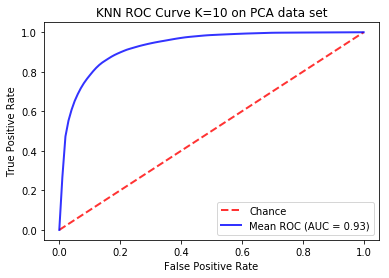

In [29]:
KNN_classifier = KNeighborsClassifier(n_neighbors=10)
Plot_clf_ROC(principal_components,year1_label,KNN_classifier, title = "KNN ROC Curve K=10 on PCA data set")

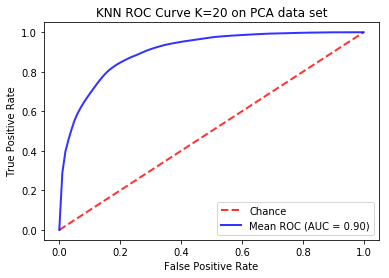

In [59]:
KNN_classifier = KNeighborsClassifier(n_neighbors=20)
Plot_clf_ROC(principal_components,year1_label,KNN_classifier, title = "KNN ROC Curve K=20 on PCA data set")

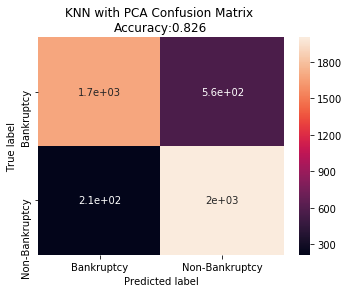

In [51]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

def confusionMatrix(X, y, clf, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)

    # Creates a confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                     index = ['Bankruptcy','Non-Bankruptcy'], 
                     columns = ['Bankruptcy','Non-Bankruptcy'])

    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title(title.format(accuracy_score(y_test, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

confusionMatrix(principal_df, year1_label, KNN_classifier, title = 'KNN with PCA Confusion Matrix \nAccuracy:{0:.3f}')

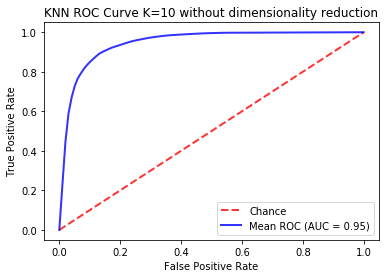

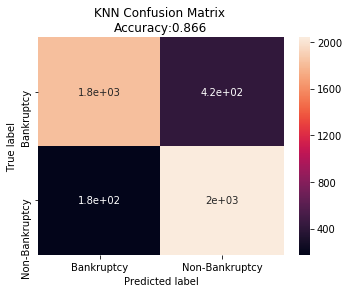

In [60]:
KNN_classifier = KNeighborsClassifier(n_neighbors=10)
year1_feature_array = np.asarray(year1_feature)
Plot_clf_ROC(year1_feature_array,year1_label,KNN_classifier, title = "KNN ROC Curve K=10 without dimensionality reduction")
confusionMatrix(year1_feature, year1_label, KNN_classifier, title = 'KNN Confusion Matrix \nAccuracy:{0:.3f}')


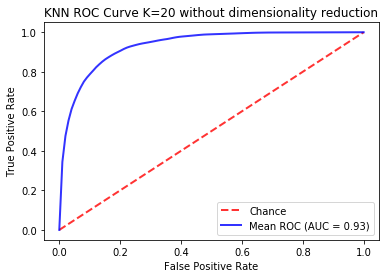

In [61]:
KNN_classifier = KNeighborsClassifier(n_neighbors=20)
Plot_clf_ROC(year1_feature_array,year1_label,KNN_classifier, title = "KNN ROC Curve K=20 without dimensionality reduction")

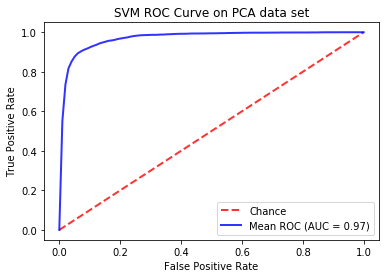

In [63]:
svm_classifier = svm.SVC(kernel='rbf',gamma = 10, probability=True)
Plot_clf_ROC(principal_components,year1_label,svm_classifier, title = "SVM ROC Curve on PCA data set")


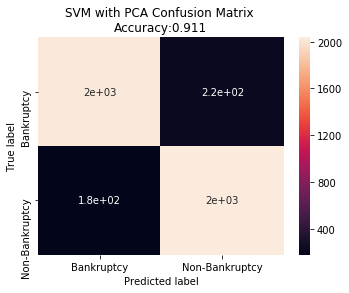

In [65]:
confusionMatrix(principal_components, year1_label, svm_classifier, title = 'SVM with PCA Confusion Matrix \nAccuracy:{0:.3f}')


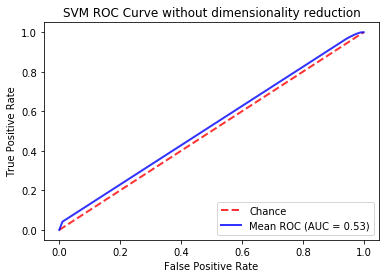

In [64]:
Plot_clf_ROC(year1_feature_array,year1_label,svm_classifier, title = "SVM ROC Curve without dimensionality reduction")


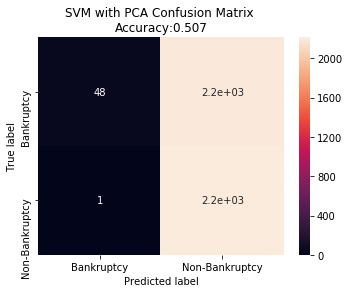

In [66]:
confusionMatrix(year1_feature_array, year1_label, svm_classifier, title = 'SVM with PCA Confusion Matrix \nAccuracy:{0:.3f}')


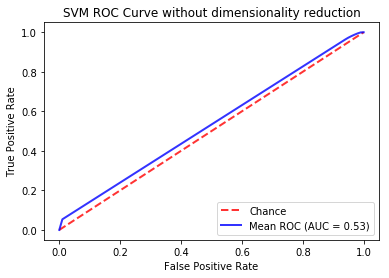

In [67]:
svm_classifier = svm.SVC(kernel='rbf',gamma = 1, probability=True)
Plot_clf_ROC(year1_feature_array,year1_label,svm_classifier, title = "SVM ROC Curve without dimensionality reduction")


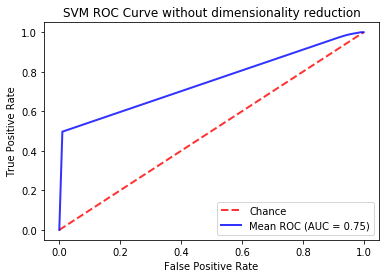

In [68]:
svm_classifier = svm.SVC(kernel='rbf', probability=True)
Plot_clf_ROC(year1_feature_array,year1_label,svm_classifier, title = "SVM ROC Curve without dimensionality reduction")


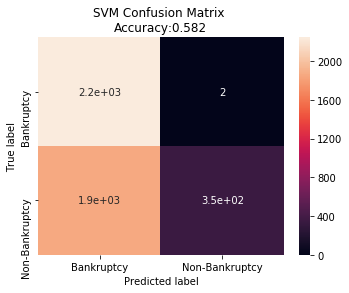

In [70]:
confusionMatrix(year1_feature_array, year1_label, svm_classifier, title = 'SVM Confusion Matrix \nAccuracy:{0:.3f}')